# Calculate displacement and momentum thickness

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

import postproamrwindsample_xarray as ppsamplexr
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def loadpickle(picklefile):
    pfile          = open(picklefile, 'rb')
    ds             = pickle.load(pfile)
    pfile.close()
    return ds

In [3]:
def calcDelta(x, y, U, Uinf):
    xvec = x[0,:]
    yvec = y[:,0]
    deltaInt = 1.0 - U/Uinf
    delta = np.trapz(np.trapz(deltaInt, yvec, axis=0), xvec, axis=0)
    return delta

def calcTheta(x, y, U, Uinf):
    xvec = x[0,:]
    yvec = y[:,0]
    thetaInt = U/Uinf*(1.0 - U/Uinf)
    theta = np.trapz(np.trapz(thetaInt, yvec, axis=0), xvec, axis=0)
    return theta

In [4]:
rotorD = 127                # rotor diameter
A      = np.pi/4*rotorD**2  # Rotor Area
x0     = 2000
writeoutputs = True
datadir= 'data/'

In [5]:
RPdb_turb   = loadpickle('means/rotor_avg.pkl')
RPdb_noturb = loadpickle('../../AMR.5kmX5km_noturbine1/post_processing/means/rotor_avg.pkl')

-10.000000 0.010167 0.010161 1.000561
-8.000000 0.022329 0.022297 1.001455
-6.000000 0.045062 0.044920 1.003171
-4.000000 0.094656 0.093451 1.012898
-2.000000 0.189195 0.184194 1.027151
0.000000 0.328503 0.153689 2.137451
2.000000 0.547245 0.211402 2.588651
4.000000 0.585298 0.418466 1.398675
6.000000 0.567803 0.446768 1.270912
8.000000 0.535919 0.435943 1.229331
10.000000 0.504583 0.420027 1.201311
12.000000 0.479096 0.410568 1.166910
14.000000 0.449391 0.394748 1.138425
16.000000 0.408472 0.368039 1.109862
18.000000 0.360039 0.329604 1.092339
20.000000 0.319126 0.294943 1.081991


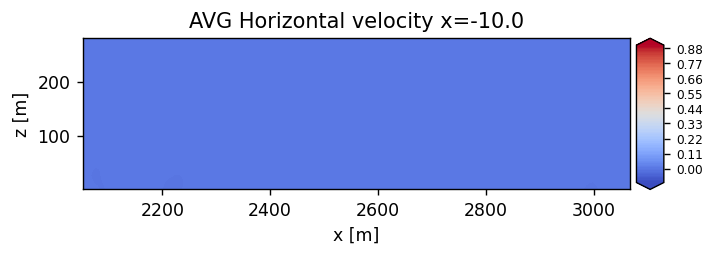

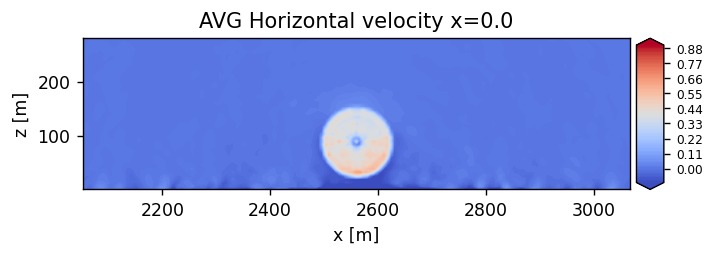

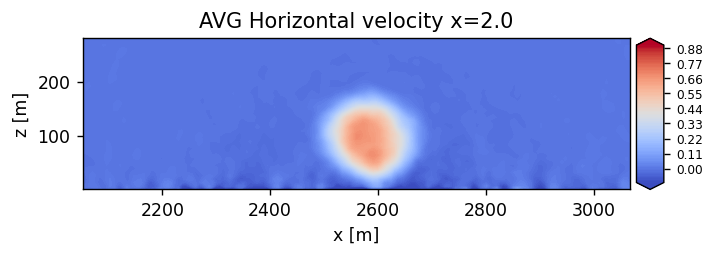

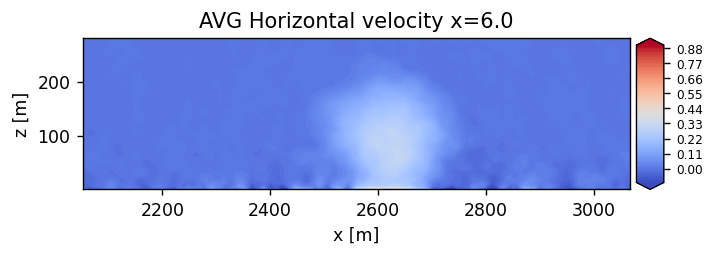

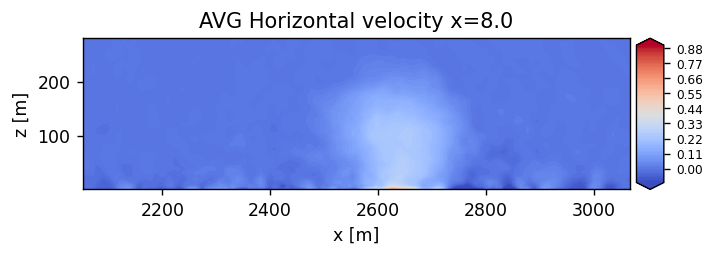

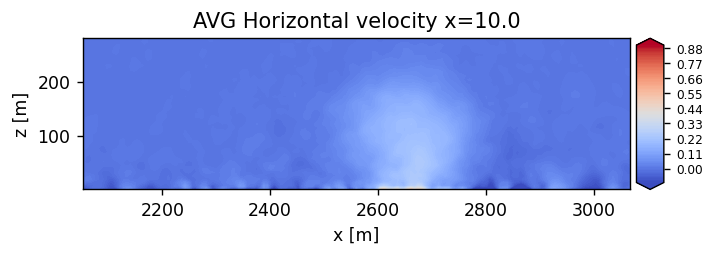

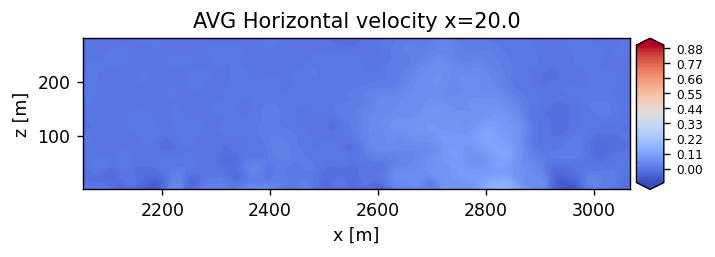

In [6]:
plotplanes = [0, 5, 6, 8, 9, 10, 15]
allplanes  = np.arange(16)

xlist = []
deltalist = []
thetalist = []
Hlist     = []

for iplane in allplanes:
    clevels = np.linspace(-0.1, 0.9, 101)
    Uh_turb=np.sqrt(RPdb_turb['velocityx_avg'][iplane,:,:]**2+RPdb_turb['velocityy_avg'][iplane,:,:]**2)
    Uh_noturb=np.sqrt(RPdb_noturb['velocityx_avg'][iplane,:,:]**2+RPdb_noturb['velocityy_avg'][iplane,:,:]**2)
    deltaXY = 1 - Uh_turb/Uh_noturb
    y = RPdb_turb['y'][iplane,:,:]
    z = RPdb_turb['z'][iplane,:,:]
    delta = calcDelta(y, z, Uh_turb, Uh_noturb)
    theta = calcTheta(y, z, Uh_turb, Uh_noturb)
    H     = delta/theta
    xplane = np.mean(RPdb_turb['x'][iplane,:,:])-x0
    xlist.append(xplane)
    deltalist.append(delta)
    thetalist.append(theta)
    Hlist.append(H)
    print('%f %f %f %f'%(xplane/rotorD, delta/A, theta/A, H))

    if iplane in plotplanes:
        fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=125)
        c = plt.contourf(y, z, deltaXY, levels=clevels, cmap='coolwarm', extend='both')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar=fig.colorbar(c, ax=ax, cax=cax)
        cbar.ax.tick_params(labelsize=7)
        ax.axis('scaled')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('z [m]')
        ax.set_title('AVG Horizontal velocity x=%0.1f'%(xplane/rotorD))


In [7]:
# Save the data
if writeoutputs:
        savedat = np.vstack((np.array(xlist)/rotorD, np.array(deltalist)/A, np.array(thetalist)/A, np.array(Hlist),))
        fname   = f'AMRWIND_DeltaThetaH_Thickness.dat'
        np.savetxt(datadir+'/'+fname, savedat.transpose(), header="X/D Delta/A Theta/A H")